<a href="https://colab.research.google.com/github/ZeyuSun/thor/blob/main/pathway_kpca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb

In [ ]:
import os
from glob import glob
from ipdb import set_trace as bp

import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds as svds
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

In [ ]:
!gdown --id 1_BVRFD8qxMSStHkYba4xrJUaLNOC5Aq3
!gdown --id 1Xt97A0LRhuAoum0rpHHbEGC2oRHa-jJh
!gdown --id 1S1vrLessTvWeA-TOBQaqs2osb5tYVT_6
!gdown --id 1lWi8Eqrx-DwLBZzyu6od0l8g-4qLJqvw
!gdown --id 1LWO5nfUbRIZ5Ak9twU9SjqtQXrn3tCHk
!gdown --id 1n4pnqgmj0cEDcxvYG6eZ-nPtjPp3Qoks

Downloading...
From: https://drive.google.com/uc?id=1_BVRFD8qxMSStHkYba4xrJUaLNOC5Aq3
To: /content/Pathways_B.csv
100% 203k/203k [00:00<00:00, 61.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xt97A0LRhuAoum0rpHHbEGC2oRHa-jJh
To: /content/Pathways_F.csv
100% 154k/154k [00:00<00:00, 48.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S1vrLessTvWeA-TOBQaqs2osb5tYVT_6
To: /content/Pathways_K.csv
100% 207k/207k [00:00<00:00, 78.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lWi8Eqrx-DwLBZzyu6od0l8g-4qLJqvw
To: /content/RNASeq_B.csv
100% 1.52M/1.52M [00:00<00:00, 99.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LWO5nfUbRIZ5Ak9twU9SjqtQXrn3tCHk
To: /content/RNASeq_F.csv
100% 317k/317k [00:00<00:00, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n4pnqgmj0cEDcxvYG6eZ-nPtjPp3Qoks
To: /content/RNASeq_K.csv
100% 1.65M/1.65M [00:00<00:00, 106MB/s]


In [19]:
# Constants
SPECIES = ['B', 'F', 'K']
COMMUNITIES = ['B', 'F', 'K', 'BF', 'FK', 'BK', 'BFK']

pathways = {}
rnaseq = {}
for s in SPECIES:
    pathways_file = 'Pathways_{}.csv'.format(s)
    df = pd.read_csv(pathways_file, index_col='geneID').dropna()
    df = df[~df.index.duplicated(keep='first')]
    pathways[s] = df
for s in SPECIES:
    rnaseq_file = 'RNASeq_{}.csv'.format(s)
    rnaseq[s] = pd.read_csv(rnaseq_file, index_col=0).dropna()
    rnaseq[s]

## Kronecker PCA implementation



In [ ]:
class KronPCA:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        
    @staticmethod
    def rearrange(A, m1, m2, n1, n2):
        """Rearrange: slice, transpose, combine, transpose (Van Loan, 1993)
        
        Args:
            A: Input matrix comprising m1 x n1 block matrices of size m2 x n2
            m1, m2: hierarchical sizes along axis 0
            n1, n2: hierarchical sizes along axis 1
            
        Returns:
            R: Rearranged matrix comprising n1 x n2 block matrices of size m1 x m2
        """
        R = A.reshape(m1,m2,n1,n2).transpose(2,0,3,1).reshape(n1*m1,n2*m2)
        return R
    
    def fit(self, X,
            beta=0,
            names=["A", "B", "Ainv", "Binv", "Ap", "Bp", "spectrum", "Chat", "C"],
            method="svds",
            rescale=False):
        """
        Args:
            X: n-by-(p*q) data matrix
            names: quantities to estimate
        """
        assert X.shape[1] == self.p * self.q, ("Dimension mismatch: ",
            "X.shape = {}, p = {}, q = {}".format(X.shape, self.p, self.q))

        C = np.cov(X.T, bias=True) #14s C.shape=30720x30720
        R = self.rearrange(C, self.p, self.q, self.p, self.q) #14s
        if method == "svds":
            U, D, Vh = svds(R, 1) #14s
        elif method == "svd":
            U, D, Vh = np.linalg.svd(R, full_matrices=False)
        else:
            raise ValueError("Invalid method: {}".format(method))

        sign = lambda x: int((x>0)*2-1)
        est = {}
        if "A" in names or "Ainv" in names or "Ap" in names or "Chat" in names:
            est["A"] = U[:,0].reshape(self.p,self.p) * sign(U[0,0])
            if "Ainv" in names or "Ap" in names:
                est["Ainv"] = np.linalg.inv(est["A"])
                if "Ap" in names:
                    est["Ap"] = np.linalg.cholesky(est["Ainv"]).T # assumption: Ap is normal matrix
        if "B" in names or "Binv" in names or "Bp" in names or "Chat" in names:
            est["B"] = Vh[0].reshape(self.q,self.q) * sign(Vh[0,0])
            if "Binv" in names or "Bp" in names:
                est["Binv"] = np.linalg.inv(est["B"])
                if "Bp" in names:
                    est["Bp"] = sqrtm(est["Binv"]) #np.linalg.cholesky(est["Binv"]).T
        if "spectrum" in names or "Chat" in names:
            soft = lambda x, t: np.sign(x) * np.maximum(0, np.abs(x) - t)
            est["spectrum"] = soft(D, beta)
        if "C" in names:
            est["C"] = C
        if "Chat" in names:
            est["Chat"] = est["spectrum"][0] * np.kron(est["A"], est["B"]) #np.outer(U[:,0], Vh[0]) #>60s

        if rescale:
            c_Ap = 1 / np.mean(np.diag(est["Ap"]))
            est["Ap"] *= c_Ap
            est["Ainv"] *= c_Ap**2
            est["A"] /= c_Ap**2

            c_Bp = 4 / np.mean(np.diag(est["Bp"]))
            est["Bp"] *= c_Bp
            est["Binv"] *= c_Bp**2
            est["B"] /= c_Bp**2

            est["spectrum"] *= c_Ap**2 * c_Bp**2

        self.est = est
        #bp()
        for name in est:
            setattr(self, name, est[name])

        return self

In [ ]:
def plot_kpca(kpca, A_ticks, B_ticks, title):
    plt.figure(figsize=(12,10))
    imshow = lambda X, *args, **kwargs: plt.imshow(X, vmin=X.min(), vmax=X.max(),
        norm=mcolors.TwoSlopeNorm(vmin=min(-1e-8,X.min()),
                                  vcenter=0,
                                  vmax=max(1e-8,X.max())),
        *args, **kwargs)

    plt.subplot(221)
    imshow(kpca.A)
    plt.colorbar()
    plt.yticks(range(kpca.A.shape[0]), A_ticks)
    plt.title('Pathway $\hat{A}$')

    plt.subplot(222)
    imshow(kpca.Ap)
    plt.colorbar()
    plt.title('Pathway $\hat{A_p}$')

    plt.subplot(223)
    imshow(kpca.B)
    plt.colorbar()
    plt.xticks(range(kpca.B.shape[0]), B_ticks)
    plt.yticks(range(kpca.B.shape[0]), B_ticks)
    plt.title('Community $\hat{B}$')

    plt.subplot(224)
    imshow(kpca.Bp)
    plt.xticks(range(kpca.B.shape[0]), B_ticks)
    plt.yticks(range(kpca.B.shape[0]), B_ticks)
    plt.colorbar()
    plt.title('Community $\hat{B_p}$')
    
    plt.suptitle(title)
    plt.show()

## Run KPCA on pathway data

In [ ]:
def run_kpca(species, replicates, kmin):
    """Pathway correlation analysis using the RNA-Seq data of a species.

    Args:
        species (str): The species of the RNAseq data. Can be 'B', 'F', or 'K'.
        replicates (list of list of str): List of list of names of replicated experiments.
            E.g., [['B1',...,'B4'],['BF1',...,'BF4'],...].
        kmin (int): The smallest number of genes needed in a pathway for it to
            be selected.
        par_corr (bool): If true, cluster pathways using partial correlation.
            Otherwise, use correlation. Default to False.
    """
    df = pd.concat([pathways[species], rnaseq[species]], axis=1, join='inner')
    new_df = (df.groupby('DescC', as_index=False)
                .filter((lambda x: len(x) >= kmin))
                .groupby('DescC') #, as_index=False)
                .nth(list(range(kmin)))
    )
    data = new_df.to_numpy().reshape(-1,kmin,*np.shape(replicates))
    n_pathways, n_genes, n_reps, n_comms = data.shape
    data = data.transpose((1,2,0,3)).reshape(n_genes*n_reps, n_pathways*n_comms)
    kpca = KronPCA(n_pathways, n_comms)
    kpca.fit(data)

    pathway_names = new_df.index.unique().to_numpy()
    community_names = [r[0][:-1] for r in replicates]
    title = 'KPCA results on {}'.format(species)
    plot_kpca(kpca, [p+'  '+str(i) for i, p in enumerate(pathway_names)],
              community_names, title)

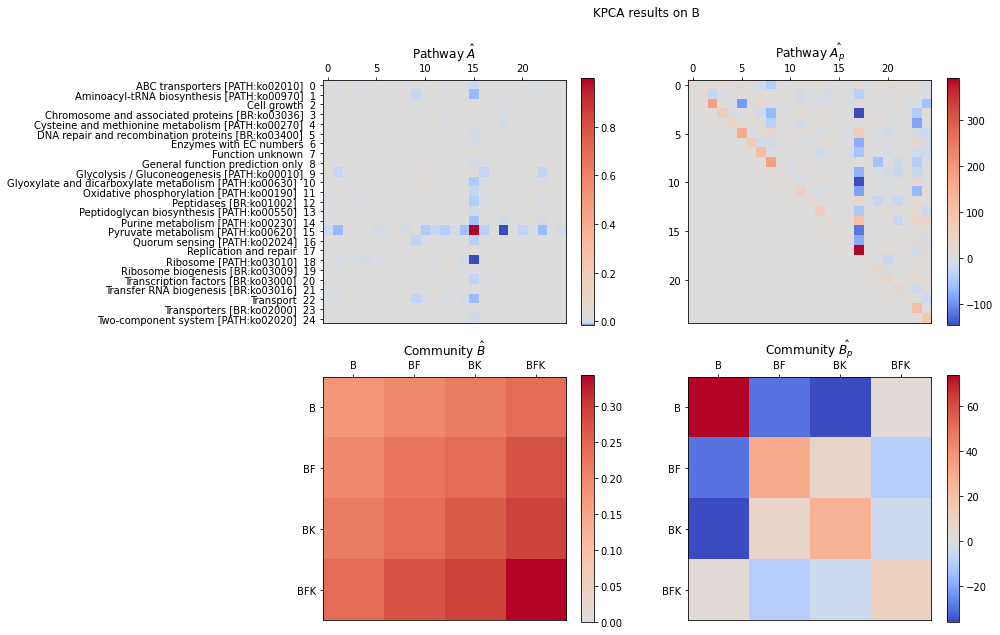

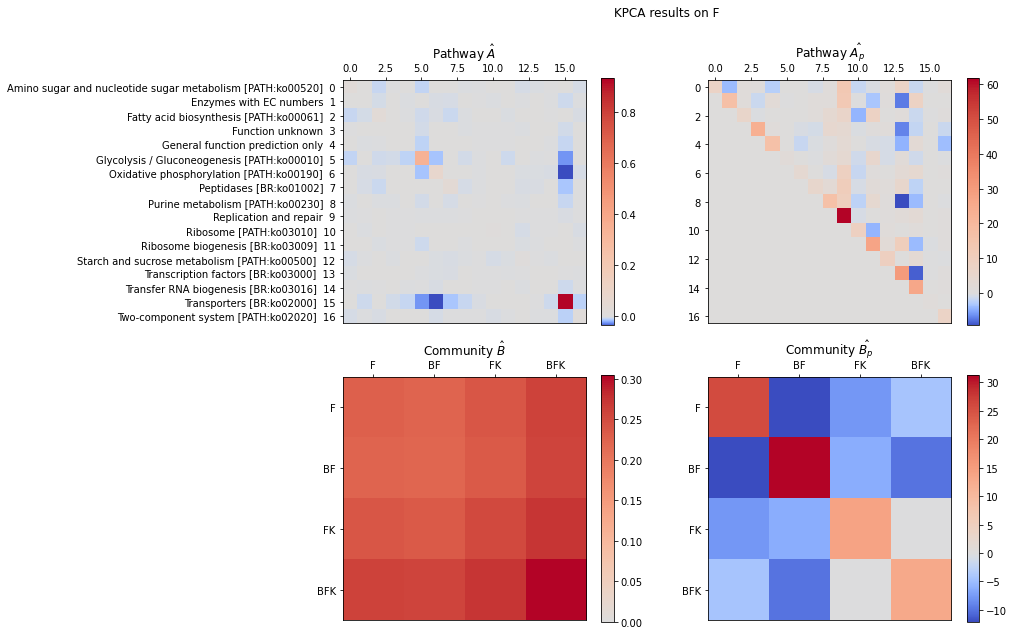

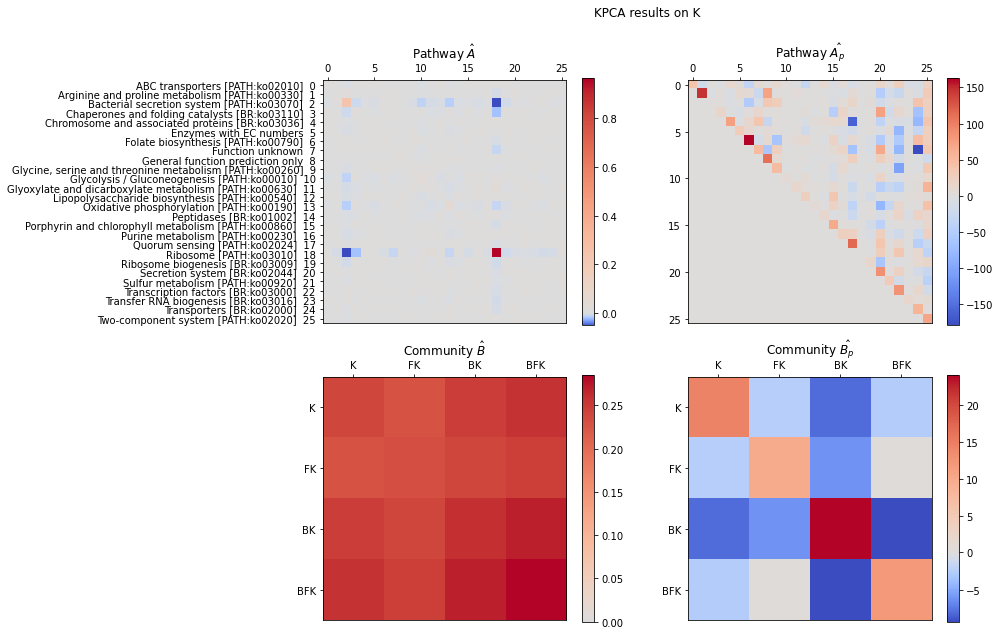

In [ ]:
kmin = 30 # minimum genes in a pathway
N = 4 # number of replicates

for sp in SPECIES:
    lengths = pathways[sp].groupby('DescC').size()
    top_pathways = lengths[lengths >= kmin].index.sort_values()
    reps = [[c+str(i) for i in range(1,1+N)] for c in COMMUNITIES if sp in c]
    run_kpca(sp, reps, kmin=kmin)

In [ ]:
%debug

> /usr/local/lib/python3.6/dist-packages/matplotlib/colors.py(1103)__init__()
   1101                              'ascending order')
   1102         if vcenter is not None and vmin is not None and vcenter <= vmin:
-> 1103             raise ValueError('vmin, vcenter, and vmax must be in '
   1104                              'ascending order')
   1105 

ipdb> p vmin, vcenter, vmax
(0, 0, 0.34406509295254667)
ipdb> q


* Correlation -> thresh
* B is not PD -> ML guarantee PD